# Using Word2Vec Embedding to extend unsupervised guesser POC

We can use Gensim to make a more powerful version of our unsupervised Proof-of-Concept. Let's see if we can make less of a toy version using the Google News Skip-Gram model with 300-feature embeddings (requires ~2GB).

In [1]:
import decryptoai.word2vec_loader.loader as wv_loader

limit = 200_000
print(f"Loading {limit} keys")
google_news_wv = wv_loader.load_word2vec_keyedvectors(limit=limit, debug=True)

Loading 200000 keys


In [2]:
# pre-normalize all the vectors
google_news_wv.unit_normalize_all()

# Modelling a stronger Guesser

Now that we have a bit of a grasp on how the Google News Word2Vec model is compatible with our Decrypto words from the word2vec integration notebook, let's build a stronger guesser and compare some different probability schemes.

We'll start with some strategies that simply manipulate the cosine similarity. I expect these to perform poorly for 2 reasons.

One is that the cosine similarity doesn't really correspond to something probablistic, so in a way we are using it more as a heuristic. This could backfire because it doesn't really take word context or word frequency into account.

Another more subtle reason is that the cosine similarity is symmetric. This implies that the probability of using a clue for a keyword is the same as the probability of using the keyword as a clue for the clue word if it was the keyword (that was a mouthful). We know from Baye's Theorem this isn't quite true, because it doesn't take the probabilities/frequencies of each individual word into account, nor the density of similar neighbors each word has in the vector space.

However, they should yield much better guesses than random because the embeddings store a lot of semantic information.

Importantly, let's not forget to use log probabilities/heuristics due to our design choice in Guesser Proof-Of-Concept.

In [6]:
import numpy as np

def cosine_similarity(clue_index, keyword_index):
    clue_embedding = google_news_wv[clue_index.squeeze()].transpose()
    keyword_embedding = google_news_wv[keyword_index.squeeze()]
    return np.expand_dims(keyword_embedding.dot(clue_embedding), axis=-1)

# simple heuristics

def log_square_cosine_similarity(clue_index, keyword_index):
    similarity = cosine_similarity(clue_index, keyword_index)
    return 2 * np.log(np.abs(similarity))

def log_normalized_cosine_similarity(clue_index, keyword_index):
    similarity = cosine_similarity(clue_index, keyword_index)
    normalized_similiarity = (1 + similarity) / 2
    return np.log(normalized_similiarity)

See datamuse notebook if you don't have the csv files. We're going to use them to evaluate the heuristics.

In [7]:
import pandas
import decryptoai.config as cfg

meaning_df = pandas.read_csv(cfg.MEANING_CSV_PATH)
triggerword_df = pandas.read_csv(cfg.TRIGGERWORD_CSV_PATH)

In [8]:
import numpy as np
import swifter
import decryptoai.players.unsupervised.numpy_guesser as nguesser

from collections import defaultdict
from dataclasses import dataclass
from functools import partial

@dataclass
class Suite:
    name: str
    clue_df: pandas.DataFrame
    correct_code_index: pandas.Series

def get_guess(strat_func, input_row):
    keyword_card = (input_row.keyword1, input_row.keyword2, input_row.keyword3, input_row.keyword4)
    clues = (input_row.clue1, input_row.clue2, input_row.clue3)
    wv_kw_card = map(wv_loader.official_keyword_to_word, keyword_card)
    random_vars = nguesser.guesser_random_variables(wv_kw_card, google_news_wv.key_to_index)
    code_log_probabilities = nguesser.log_expected_probabilities_codes(strat_func, random_vars, nguesser.np_clues(clues, google_news_wv.key_to_index))
    code_index_guess = np.argmax(code_log_probabilities)
    return pandas.Series([code_index_guess, code_log_probabilities[code_index_guess]], index=["code_index_guess", "log_expected_prob"])

meaning_clue_df, meaning_correct_code_index = meaning_df.drop('code_index', axis=1), meaning_df['code_index']
triggerword_clue_df, triggerword_correct_code_index = triggerword_df.drop('code_index', axis=1), triggerword_df['code_index']

suites = [Suite("meaning", meaning_clue_df, meaning_correct_code_index), Suite("triggerword", triggerword_clue_df, triggerword_correct_code_index)]

strat_funcs = [log_square_cosine_similarity, log_normalized_cosine_similarity]
guesses_by_suitename_and_strat = defaultdict(dict)
for strat_func in strat_funcs:
    print(strat_func.__name__)
    get_guess_with_strat = partial(get_guess, strat_func)

    for suite in suites:
        guesses = suite.clue_df.swifter.apply(get_guess_with_strat, axis=1)
        guesses["correct"] = guesses["code_index_guess"] == suite.correct_code_index
        percent_correct = 100 * np.sum(guesses["correct"]) / len(guesses)
        print(f"percent {suite.name} clues correct: {percent_correct:.2f}%")
        guesses_by_suitename_and_strat[suite.name][strat_func] = guesses

log_square_cosine_similarity


Pandas Apply: 100%|██████████| 36000/36000 [00:34<00:00, 1046.36it/s]


percent meaning clues correct: 65.21%


Pandas Apply: 100%|██████████| 36000/36000 [00:37<00:00, 964.41it/s] 


percent triggerword clues correct: 77.30%
log_normalized_cosine_similarity


Pandas Apply: 100%|██████████| 36000/36000 [00:26<00:00, 1340.60it/s]


percent meaning clues correct: 67.04%


Pandas Apply: 100%|██████████| 36000/36000 [00:27<00:00, 1294.73it/s]

percent triggerword clues correct: 78.25%


Our naive guessers are performing very well! If they were to be guessing randomly, or always producing the same code, we should expect that they only get about 1 in 24 correct, or about 4.17% correct! This is better than I was expecting in terms of correctness; we may be able to get better correctness with better heuristics. 

From the time it took to evaluate and from the swifter output, we can also conclude that 1000 to 1500 guesses occured a second, meaning each guess takes 0.6 to 1 milliseconds. Refactoring in NumPy sped this up by 10 times!

A couple more probabilistic heuristics would be perhaps to take the cosine similarity as a proportion of similarity to all words in the dataset. Another might be to take the the number of words with a cosine distance from the keyword that is greater than the clue distance from the keyword as a proportion of all words in the dataset. Not only are these more probabilistic in nature, but the more subtle trait of being asymmetric in the previously described sense.

Tuning these metrics with parameters that depend on frequency may also be of relevance. Since we don't have that data through Gensim, [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) may be useful.

We should look into the naive guesser's performance a bit better, though. Does it have a false sense of confidence for incorrect guesses? Is it simililarly unsure about all of its guesses? Are the clues it is getting wrong reasonable to get wrong, or is there an obvious pattern that it is missing?

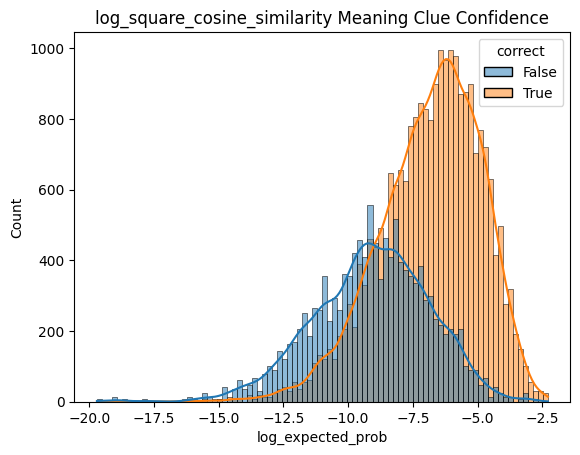

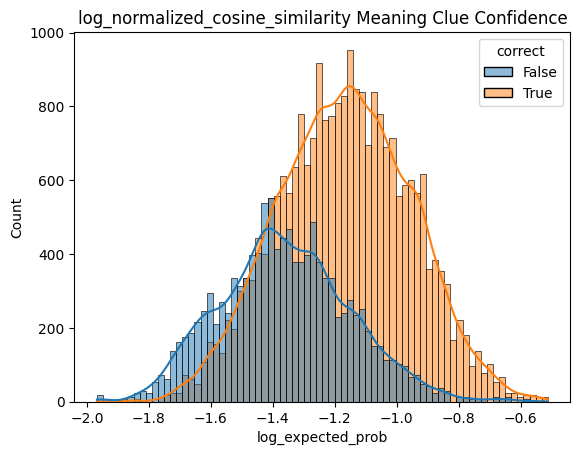

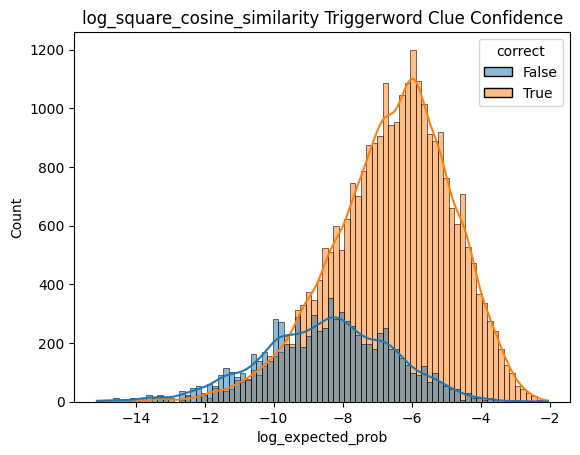

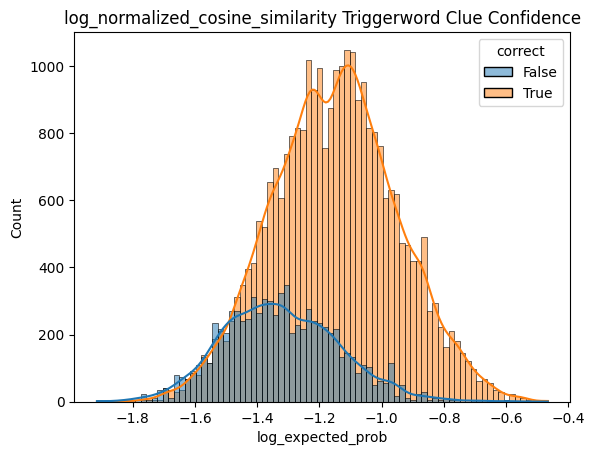

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

for suite in suites:
    for strat_func, meaning_guesses_df in guesses_by_suitename_and_strat[suite.name].items():
        _, ax = plt.subplots()
        plot = sns.histplot(ax=ax, data=meaning_guesses_df, x="log_expected_prob", hue="correct", kde=True)
        plot.set(title=f'{strat_func.__name__} {suite.name.capitalize()} Clue Confidence')


Fortunately, we observe that the guessers don't have a false sense of confidence. They assign their incorrect guesses significantly lower probabilities than they assign their correct guesses.

The distributions are also not showing erratic behavior or an obvious pitfall, implying the guessing is working how we expect.

In [13]:
%%capture --no-display

guessed_wrong_by_suitename_and_strat = defaultdict(dict)
for suite in suites:
    for strat_func, guesses_df in guesses_by_suitename_and_strat[suite.name].items():
        wrong_guesses = guesses_df["correct"] == False
        guessed_wrong = suite.clue_df[wrong_guesses]
        guessed_wrong["guessed_code_index"] = guesses_df["code_index_guess"][wrong_guesses]
        guessed_wrong["correct_code_index"] = suite.correct_code_index[wrong_guesses]
        guessed_wrong_by_suitename_and_strat[suite.name][strat_func] = guessed_wrong

guessed_wrong_by_suitename_and_strat["meaning"][log_square_cosine_similarity].head()


,keyword1,keyword2,keyword3,keyword4,clue1,clue2,clue3,guessed_code_index,correct_code_index
0,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,electricians,leg,14.0,0
1,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,electricians,ancestry,15.0,1
2,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,leg,electricians,12.0,2
3,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,leg,ancestry,13.0,3
4,BUTTERFLY,PLUMBER,FOOT,BLOOD,throttle,ancestry,electricians,17.0,4


We see that some of the mistakes the guessers are making are reasonable. A guesser guessed that "butterfly" and "leg" went together more well than "butterfly" and "throttle". In the context of the first guess, it might make sense to say "foot" goes with "throttle" and "butterfly" goes with "leg" just as much as the other way around.

There are 2 primary things to note. One is that the performance of our Guessers rely somewhat on the competence of the Encryptor. We observe that the Encryptor isn't taking into account that some of its choice words may make sense for multiple keywords and result in a conflict.

The other thing to note is that our Guesser may be having trouble with scale, as predicted. We see that it often sticks with a word that seems "most fit" without scaling how fit it is to how common the word is, or how commonly the words are used together. A different heuristic may help with this.

Let's try some of the other ideas I had. That is, scaling the probabilities by word frequency. We can use Zipf's law to approximate frequency. We might also consider a more intutive approach, where we realize that a guess will be harder to get the farther away from the keyword it is.

The Zipf implementation uses Baye's Theorem; we say P(clue | keyword) = (P(clue) / P(keyword)) * P(keyword | clue). To get the probailiities of the individual words, we use Zipf's law, and substitute 1/rank in the Google keyedvectors instance. This leaves us with (rank_keyword / rank_clue) * P(keyword | clue), where we might use one of our previous metrics to get the remaining probability. Let's see how our algorithm performs with these approaches.

As a sanity check, let's also include the Zipf scalings themselves. It should perform poorly because it doesn't compare any embeddings directly, and therefore can't give any information on word similarity apart from if they are similarly frequent. We should expect near random guesses at about 4.166% accuracy.

In [14]:
def cosine_distance(clue_index, keyword_index):
    return 1 - cosine_similarity(clue_index, keyword_index)

def log_zipf(clue_index, keyword_index):
    return np.log(keyword_index) - np.log(clue_index)

def log_outer_radius_proportion(clue_index, keyword_index):
    clue_distance = cosine_distance(clue_index, keyword_index)
    all_word_indices = np.arange(len(google_news_wv))
    all_distances = cosine_distance(np.expand_dims(all_word_indices, axis=-1), keyword_index).swapaxes(-1, -2)
    num_outside =  (all_distances > clue_distance).sum(axis=-1)
    return np.log(num_outside) - np.log(len(google_news_wv))

def log_zipf_scaled(clue_index, keyword_index):
    return log_zipf(clue_index, keyword_index) + log_square_cosine_similarity(clue_index, keyword_index)

def log_outer_radius_proportion_scaled(clue_index, keyword_index):
    return log_outer_radius_proportion(clue_index, keyword_index) + log_square_cosine_similarity(clue_index, keyword_index)